In [1]:

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model

import matplotlib.pyplot as plt
import seaborn as sb

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:

directory ="D:\medicinal\Medicinal plant dataset"

In [3]:
batch_size = 64
IMG_SIZE = (224, 224, 3)

In [4]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True,
    )

Found 5945 files belonging to 40 classes.
Using 4756 files for training.


In [5]:

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True
    )


Found 5945 files belonging to 40 classes.
Using 1189 files for validation.


In [6]:
class_names = train_ds.class_names

In [7]:

np.save("D:\medicinal\Medicinal Leaf dataset", class_names)

In [8]:
NUM_CLASSES = 40

# Sample of Training data





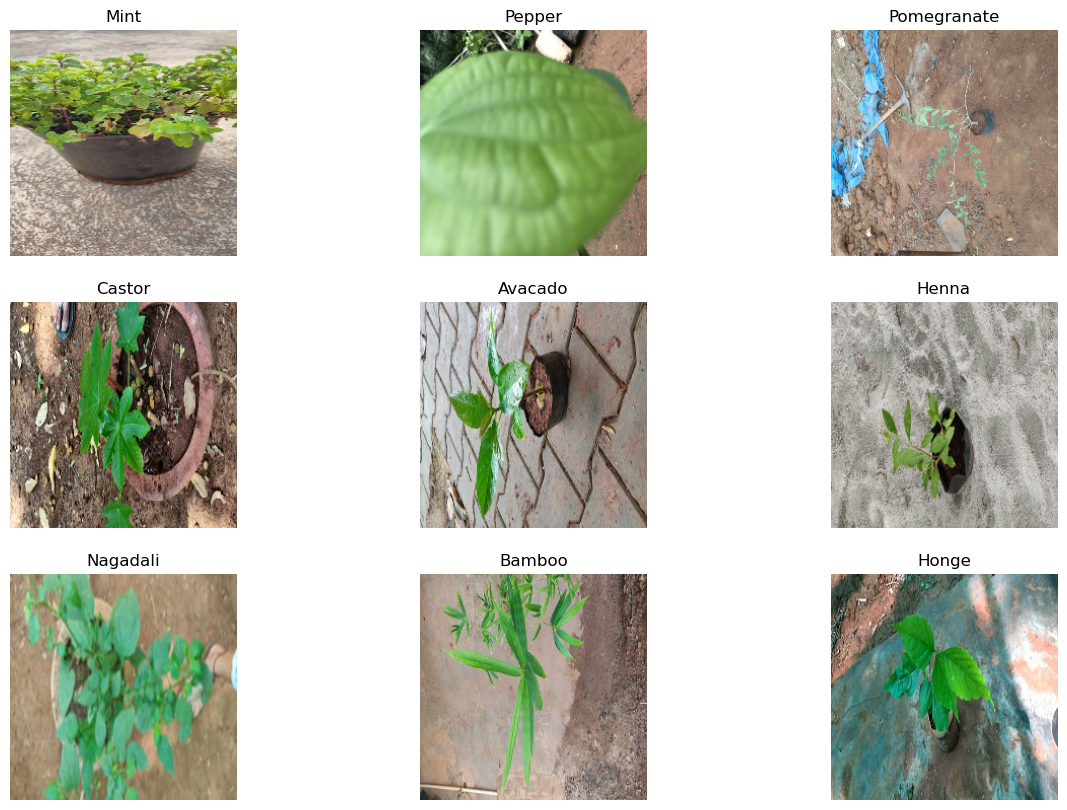

In [9]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Modelling


In [11]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

In [12]:
pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
           input_tensor=keras.Input(shape=IMG_SIZE))

In [13]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 14, 14, 512)          66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 14, 14, 512)          0         ['max_pooling2d_1[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 14, 14, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [14]:

model = keras.Sequential([
    data_augmentation,                                                    
    pre_trained_layers,                                                   
    keras.layers.GlobalAveragePooling2D(),                               
    keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')  
])


In [15]:

EPOCHS = 20
LR = 1e-3

In [16]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:

model.build((1,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (1, 2048)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 output (Dense)              (1, 40)                   81960     
                                                                 
Total params: 23646760 (90.21 MB)
Trainable params: 23601320 (90.03 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [18]:
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [19]:
import numpy as np


num_samples = epochs.shape[0]
num_classes = 30


y_one_hot = np.zeros((num_samples, num_classes))
for i in range(num_samples):
    y_one_hot[i, y[i]] = 1

NameError: name 'epochs' is not defined

In [ ]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds, callbacks=callback)


In [ ]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
Y_train = []
X_train = []

In [ ]:
for data in train_ds:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())

In [ ]:
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

In [ ]:
y_train_pred_prob.shape

In [ ]:

#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=class_names)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{class_names[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )
    
    return fig


In [ ]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [ ]:

print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

In [ ]:
roc_auc_curve(y_train_pred_prob, Y_train)

In [ ]:
X_test = []
y_test = []

In [ ]:

for data in validation_ds:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

In [ ]:
np.unique(y_test)

In [ ]:

plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [20]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test


NameError: name 'classification_report' is not defined

In [21]:
roc_auc_curve(y_test_pred_prob, y_test)

NameError: name 'roc_auc_curve' is not defined

In [22]:
from tensorflow.keras.models import save_model